In [62]:
from theano.sandbox import cuda

In [63]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [95]:
# path = "/opt/notebooks/data/movielens/ml-20m/"
path = "/opt/notebooks/data/movielens/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=32

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [96]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [97]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [98]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [99]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [100]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [101]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [102]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [103]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [104]:
n_factors = 50

In [105]:
np.random.seed = 42

Randomly split into training and validation.

In [75]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [76]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [77]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [78]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [79]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [80]:
top_r

,userId,movieId,rating,timestamp,rating_r,rating_r
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247
40153,293,417,4.0,1047071649,947,247
43329,310,417,3.0,898007830,1019,247
51144,379,417,4.0,1048092869,1063,247
61432,451,417,3.5,1133735252,1340,247
65657,467,417,4.0,1296195523,1291,247


In [81]:
pd.crosstab??

In [82]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [83]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [84]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [114]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/1
80133/80133 [==============================] - 4s - loss: 1.8976 - val_loss: 2.7114


In [115]:
model.optimizer.lr=0.01

In [116]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/3
80133/80133 [==============================] - 3s - loss: 1.8887 - val_loss: 2.7201
Epoch 2/3
80133/80133 [==============================] - 3s - loss: 1.8813 - val_loss: 2.7337
Epoch 3/3
80133/80133 [==============================] - 3s - loss: 1.8721 - val_loss: 2.7483


In [117]:
model.optimizer.lr=0.001

In [118]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/6
80133/80133 [==============================] - 3s - loss: 1.8661 - val_loss: 2.7600
Epoch 2/6
80133/80133 [==============================] - 3s - loss: 1.8590 - val_loss: 2.7721
Epoch 3/6
80133/80133 [==============================] - 3s - loss: 1.8542 - val_loss: 2.7816
Epoch 4/6
80133/80133 [==============================] - 3s - loss: 1.8493 - val_loss: 2.7941
Epoch 5/6
80133/80133 [==============================] - 3s - loss: 1.8447 - val_loss: 2.8051
Epoch 6/6
80133/80133 [==============================] - 3s - loss: 1.8400 - val_loss: 2.8107


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [119]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [120]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [121]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [122]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [123]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [124]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/1
80133/80133 [==============================] - 3s - loss: 8.7895 - val_loss: 3.5708


In [125]:
model.optimizer.lr=0.01

In [126]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/6
80133/80133 [==============================] - 3s - loss: 2.5916 - val_loss: 2.3537
Epoch 2/6
80133/80133 [==============================] - 3s - loss: 1.9970 - val_loss: 2.1472
Epoch 3/6
80133/80133 [==============================] - 3s - loss: 1.8314 - val_loss: 2.0537
Epoch 4/6
80133/80133 [==============================] - 3s - loss: 1.7328 - val_loss: 1.9733
Epoch 5/6
80133/80133 [==============================] - 3s - loss: 1.6501 - val_loss: 1.9056
Epoch 6/6
80133/80133 [==============================] - 3s - loss: 1.5748 - val_loss: 1.8354


In [127]:
model.optimizer.lr=0.001

In [133]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/10
80133/80133 [==============================] - 3s - loss: 0.7354 - val_loss: 1.1441
Epoch 2/10
80133/80133 [==============================] - 3s - loss: 0.7069 - val_loss: 1.1231
Epoch 3/10
80133/80133 [==============================] - 3s - loss: 0.6812 - val_loss: 1.1049
Epoch 4/10
80133/80133 [==============================] - 3s - loss: 0.6584 - val_loss: 1.0900
Epoch 5/10
80133/80133 [==============================] - 3s - loss: 0.6386 - val_loss: 1.0772
Epoch 6/10
80133/80133 [==============================] - 3s - loss: 0.6210 - val_loss: 1.0661
Epoch 7/10
80133/80133 [==============================] - 3s - loss: 0.6060 - val_loss: 1.0573
Epoch 8/10
80133/80133 [==============================] - 3s - loss: 0.5930 - val_loss: 1.0502
Epoch 9/10
80133/80133 [==============================] - 3s - loss: 0.5827 - val_loss: 1.0458
Epoch 10/10
80133/80133 [==============================] - 3s - loss: 0.5734 - val_loss: 1.0424

In [134]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/5
80133/80133 [==============================] - 3s - loss: 0.5662 - val_loss: 1.0400
Epoch 2/5
80133/80133 [==============================] - 3s - loss: 0.5599 - val_loss: 1.0382
Epoch 3/5
80133/80133 [==============================] - 3s - loss: 0.5550 - val_loss: 1.0378
Epoch 4/5
80133/80133 [==============================] - 3s - loss: 0.5508 - val_loss: 1.0373
Epoch 5/5
80133/80133 [==============================] - 3s - loss: 0.5475 - val_loss: 1.0376


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [135]:
model.save_weights(model_path+'bias.h5')

In [136]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [137]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.8605]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [138]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [139]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [140]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.0179038, 'Battlefield Earth (2000)'),
 (-0.56560761, 'Howard the Duck (1986)'),
 (-0.5203082, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.51022375, 'Speed 2: Cruise Control (1997)'),
 (-0.48759472, 'Jaws 3-D (1983)'),
 (-0.47253954, 'Little Nicky (2000)'),
 (-0.44315371, 'Spice World (1997)'),
 (-0.42545238, 'Wild Wild West (1999)'),
 (-0.41457227, 'Super Mario Bros. (1993)'),
 (-0.41147366, 'Police Academy 6: City Under Siege (1989)'),
 (-0.40297711, 'Godzilla (1998)'),
 (-0.38153818, 'Inspector Gadget (1999)'),
 (-0.34860793, 'Blade: Trinity (2004)'),
 (-0.33402485, 'Anaconda (1997)'),
 (-0.32380596, 'Honey, I Blew Up the Kid (1992)')]

In [141]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.8565778, 'Ran (1985)'),
 (1.8471949, 'Paris, Texas (1984)'),
 (1.8461159, 'Smoke (1995)'),
 (1.8381284, 'Shawshank Redemption, The (1994)'),
 (1.8134333, 'Lifeboat (1944)'),
 (1.7991997, 'On the Waterfront (1954)'),
 (1.7847266, 'Crumb (1994)'),
 (1.7735291, 'Godfather, The (1972)'),
 (1.7664509, 'Tom Jones (1963)'),
 (1.7513632, 'African Queen, The (1951)'),
 (1.7415932, 'It Happened One Night (1934)'),
 (1.7315952, 'Wings of Desire (Himmel \xc3\xbcber Berlin, Der) (1987)'),
 (1.7304783,
  'Triplets of Belleville, The (Les triplettes de Belleville) (2003)'),
 (1.7295969, 'Persuasion (1995)'),
 (1.7132508, 'Mister Roberts (1955)')]

We can now do the same thing for the embeddings.

In [142]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [143]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [144]:
fac0 = movie_pca[0]

In [145]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [146]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.093658544, '2001: A Space Odyssey (1968)'),
 (0.092544429, 'Pulp Fiction (1994)'),
 (0.087443396, 'Taxi Driver (1976)'),
 (0.083932638, 'Fargo (1996)'),
 (0.081386581, 'Annie Hall (1977)'),
 (0.081255883, 'Being John Malkovich (1999)'),
 (0.08019121, 'Clockwork Orange, A (1971)'),
 (0.075123064, 'Chinatown (1974)'),
 (0.070859753, 'This Is Spinal Tap (1984)'),
 (0.069394432, 'Willy Wonka & the Chocolate Factory (1971)')]

In [147]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.09057653, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.079449236, 'Stargate (1994)'),
 (-0.079016455, 'Armageddon (1998)'),
 (-0.066529557, 'Twister (1996)'),
 (-0.065630883, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.061797723, 'Lost World: Jurassic Park, The (1997)'),
 (-0.058620453, 'Titanic (1997)'),
 (-0.057269305, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.055832472, 'Ace Ventura: Pet Detective (1994)'),
 (-0.055751357, 'Home Alone (1990)')]

In [148]:
fac1 = movie_pca[1]

In [149]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [150]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.058565732, 'Island of Dr. Moreau, The (1996)'),
 (0.054047685, 'Alien: Resurrection (1997)'),
 (0.048581269, 'Lost Highway (1997)'),
 (0.046610799, 'Specialist, The (1994)'),
 (0.046001319, 'Showgirls (1995)'),
 (0.042528559, 'Escape from L.A. (1996)'),
 (0.039772544, 'Mulholland Drive (2001)'),
 (0.03862153, 'City Lights (1931)'),
 (0.038343217, 'Postman, The (Postino, Il) (1994)'),
 (0.038318079, 'Eraser (1996)')]

In [151]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.15737464, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.14969243, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.13554271, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.12400076, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.12307315, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.11580335, 'Matrix, The (1999)'),
 (-0.11571471, 'Gladiator (2000)'),
 (-0.11276316, 'Jurassic Park (1993)'),
 (-0.11223541, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.11179154, 'Braveheart (1995)')]

In [152]:
fac2 = movie_pca[2]

In [153]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [154]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.09725818, 'Beauty and the Beast (1991)'),
 (0.093228094, 'Shrek (2001)'),
 (0.093177259, 'Babe (1995)'),
 (0.08853557, 'Finding Nemo (2003)'),
 (0.083828457, 'Titanic (1997)'),
 (0.082599401, 'Ghost (1990)'),
 (0.077425547, 'Sling Blade (1996)'),
 (0.075902559, 'Erin Brockovich (2000)'),
 (0.07359007, "You've Got Mail (1998)"),
 (0.07350041, 'Sleepless in Seattle (1993)')]

In [155]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.089773953, 'Natural Born Killers (1994)'),
 (-0.08735203, 'Event Horizon (1997)'),
 (-0.081123687, 'Fight Club (1999)'),
 (-0.080080226, 'Pulp Fiction (1994)'),
 (-0.077115096, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.076712549, 'Ace Ventura: Pet Detective (1994)'),
 (-0.074754536, 'Back to the Future Part II (1989)'),
 (-0.073761493, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.072698899, 'American Psycho (2000)'),
 (-0.070470065, 'Clockwork Orange, A (1971)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [156]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

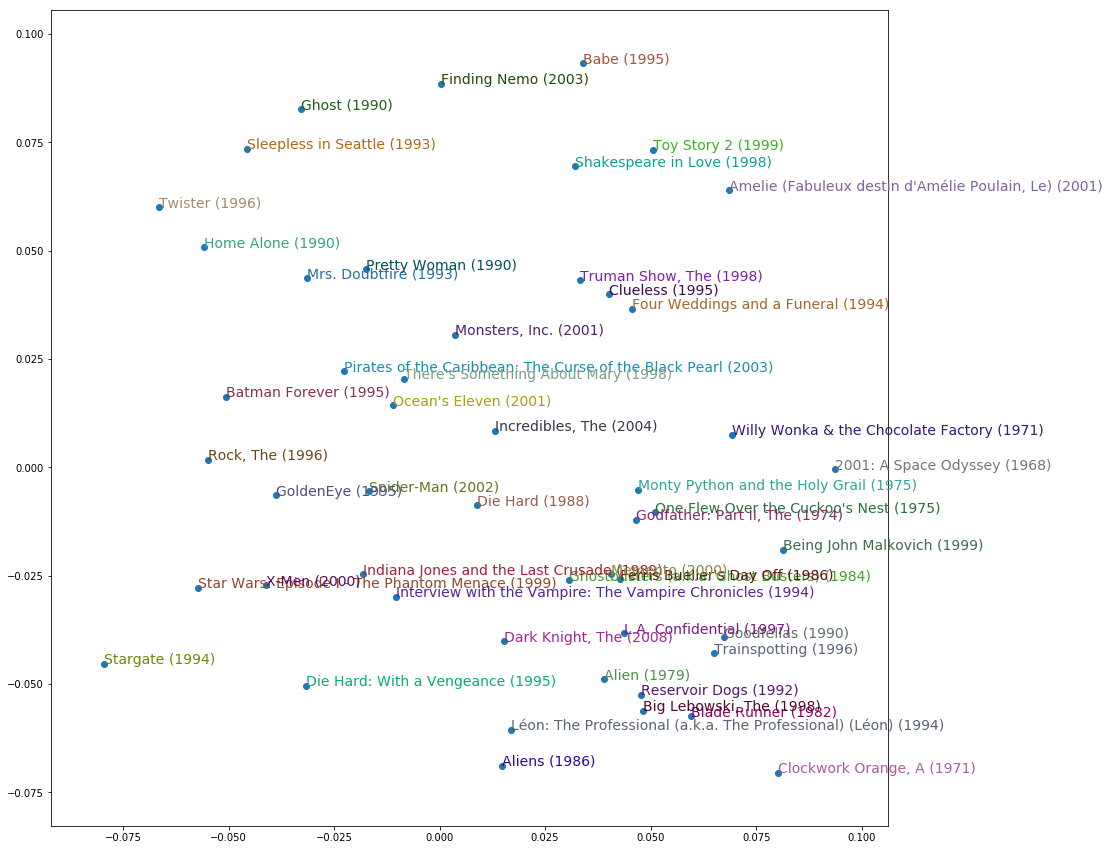

In [157]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [158]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [160]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [161]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80133 samples, validate on 19871 samples
Epoch 1/8
80133/80133 [==============================] - 4s - loss: 2.5109 - val_loss: 0.9311
Epoch 2/8
80133/80133 [==============================] - 4s - loss: 1.4969 - val_loss: 0.8888
Epoch 3/8
80133/80133 [==============================] - 4s - loss: 1.2385 - val_loss: 0.8682
Epoch 4/8
80133/80133 [==============================] - 4s - loss: 1.0339 - val_loss: 0.8624
Epoch 5/8
80133/80133 [==============================] - 4s - loss: 0.9100 - val_loss: 0.8506
Epoch 6/8
80133/80133 [==============================] - 4s - loss: 0.8426 - val_loss: 0.8478
Epoch 7/8
80133/80133 [==============================] - 4s - loss: 0.8176 - val_loss: 0.8464
Epoch 8/8
80133/80133 [==============================] - 4s - loss: 0.8029 - val_loss: 0.8503


This improves on our already impressive accuracy even further!